<a href="https://colab.research.google.com/github/doug14226/colab1/blob/master/firstMaze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#A Maze Generator with PDF file output
Copyright (c) 2018 Douglas Lange.  
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

HE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.



##Block 1 :  Install Cairo Library and Python Cairo interface

---
Install Cairo package.
Execution of this block will produce a setup.log file.
If faults occur, please download setup.log and post new issue with setup.log as attachment at https://github.com/doug14226/colab1/issues. To download setup.log run the following in a new  cell.  (to add cell press +code above)

---
from google.colab import files  
files.download("setup.log")



In [23]:
def dougpawsFirstMazeSetup():
  
  def install_not_needed():
    try:
      import cairo
      return(True)
    except ImportError:
      pass
      return(False)

  if install_not_needed():
    print("All requirements met, install not needed")
    return

  log = open("setup.log","a")

  def printlog(cmdout,log): 
    for line in cmdout:
      print(line, file = log)
      
  print("\nSetup required ", file = log)
  from datetime import datetime
  print(datetime.utcnow(), file = log)
  import sys
  print("Log Python Version", file = log)
  print(sys.version, file=log)
  cmdout = !uname -a
  print("ID OS version", file = log)
  printlog(cmdout, log)
  print("installing cairo", file = log )
  cmdout = !apt-get install libcairo2-dev
  printlog(cmdout, log)
  cmdout = !pip3 install pycairo
  printlog(cmdout, log)

  if install_not_needed():
    print("Install finished without errors")
  else:
    print("Install failed, check setup.log")

dougpawsFirstMazeSetup()    

All requirements met, install not needed


##Block 2: Class *Cell*, define data and methods of *Cell* objects.

In [0]:
class Cell:
    def __init__(self, row, column):
        self.row = row
        self.column = column
        self.directions = ('north', 'west', 'south', 'east')  # ccw order required
        self.nearby = dict()      # key is direction (i.e. 'east') value is cell object
        self.links = dict()       # key is nearby cell object value is true

    def link(self, cell, bidi=True):
        self.links[cell] = True
        if bidi is True:
            cell.link(self, False)
        return self

    def getLinks(self):
        return self.links.keys()

    def neighbors(self):
        myNeighbors = [self.nearby[d] for d in self.directions]
        return [x for x in filter(None, myNeighbors)]

    def directionToText(self, direction):
        if direction == 0:
            direction = "north"
        if direction == 1:
            direction = "east"
        if direction == 2:
            direction = "south"
        if direction == 3:
            direction = "west"
        return direction

    def fillCell(self, ctx, pointsPerCell, hue):
        yU = self.row*pointsPerCell+4
        xL = self.column*pointsPerCell+4
        ctx.rectangle(xL, yU, pointsPerCell, pointsPerCell)
        ctx.set_source_rgb(*hue)
        ctx.fill()

    def drawCell(self, ctx, pointsPerCell, rows, columns):
        yU = self.row*pointsPerCell+4
        yL = yU+pointsPerCell
        xL = self.column*pointsPerCell+4
        xR = xL+pointsPerCell
        ctx.set_source_rgb(0, 0, 0)
        ctx.set_line_width(4)
        if not(self.hasNeighbor("east")) and self.column < (columns-1):
            ctx.move_to(xR, yU-2)
            ctx.line_to(xR, yL+2)
            ctx.stroke()
        if not(self.hasNeighbor("south")) and self.row < (rows-1):
            ctx.move_to(xL, yL)
            ctx.line_to(xR, yL)
            ctx.stroke()

    def hasNeighbor(self, direction):
        direction = self.directionToText(direction)
        myNeighbor = self.nearby[direction]
        return myNeighbor in self.links

    #return Distances from this cell to all other cells
    def getDistances(self, pallet=0):
        distances = Distances(self, rootPallet=pallet)
        frontier = []
        frontier.append(self)
        while len(frontier) > 0:
            newFrontier = []
            for cell in frontier:
                for linked in cell.getLinks():
                    if distances.getDistanceTo(linked) is None:
                        dist = distances.getDistanceTo(cell)
                        distances.setDistanceTo(linked, dist+1)
                        distances.setPallet(linked, pallet)
                        newFrontier.append(linked)
            frontier = newFrontier
        return distances
             

##Block 3: Class *Grid*. define data and methods of *Grid* i.e. maze objects.

In [0]:
class Grid:
    def __init__(self, rows, columns, cellClass=Cell):
        self.CellClass = cellClass
        self.rows = rows
        self.columns = columns
        self.grid = self.prepareGrid()
        self.distances = None
        self.configureCells()
        self.pointsPerCell = 18
        self.start = None              # cell of path start
        self.goal = None               # cell of path goal
        self.ctx = None

    def prepareGrid(self):
        rowList = []
        i = 0
        j = 0
        for i in range(self.rows):
            columnList = []
            for j in range(self.columns):
                columnList.append(self.CellClass(i, j))
            rowList.append(columnList)
        return rowList

    def configureCells(self):
        for cell in self.eachCell():
            row = cell.row
            col = cell.column
            cell.nearby['north'] = self.getCell(row-1, col)
            cell.nearby['east'] = self.getCell(row, col+1)
            cell.nearby['south'] = self.getCell(row+1, col)
            cell.nearby['west'] = self.getCell(row, col-1)

    def eachRow(self):
        for row in self.grid:
            yield row

    def eachCell(self):
        for row in self.grid:
            for cell in row:
                yield cell

    def drawGrid(self, filename="maze.pdf", pointsPerCell=18 , paper='US/Letter'):
        if paper == 'US/Letter':
          WIDTH, HEIGHT = 612, 792 
        elif paper == 'A4':
          WIDTH, HEIGHT = 595, 842  
        elif paper == 'Tabloid':
          WIDTH, HEIGHT = 792, 1224  
        surface = cairo.PDFSurface(filename, WIDTH, HEIGHT) #["US/Letter", "A4", "Tabloid"]
        self.ctx = cairo.Context(surface)
        rscale = (HEIGHT - 36) / (self.rows * pointsPerCell)
        cscale = (WIDTH - 36) / (self.columns * pointsPerCell)
        scale = min(rscale, cscale)
        rsize = (self.rows * pointsPerCell) * scale
        csize = (self.columns * pointsPerCell) * scale 
        self.ctx.translate(((WIDTH - csize) / 2) - 4, ((HEIGHT - rsize) / 2) - 4)
        self.ctx.scale(scale , scale)
        self.ctx.set_line_join(cairo.LINE_JOIN_MITER)
        for row in self.grid:
            for cell in row:
                cell.drawCell(self.ctx, self.pointsPerCell, self.rows, self.columns)
        self.ctx.set_source_rgb(0, 0, 0)
        self.ctx.set_line_width(4)
        self.ctx.set_line_join(cairo.LINE_JOIN_MITER)
        self.ctx.rectangle(4, 4, self.columns*self.pointsPerCell, self.rows*self.pointsPerCell)
        self.ctx.stroke()
        self.drawOpening(self.start, (1.0, 1.0, 1.0))
        self.drawOpening(self.goal, (1.0, 1.0, 1.0))
        surface.show_page()
        for row in self.grid:
            for cell in row:
                if not self.distances.cells.get(cell, 0):
                    cell.fillCell(self.ctx, self.pointsPerCell, (0.7, 0.7, 0.7))                
        for row in self.grid:
            for cell in row:
                cell.drawCell(self.ctx, self.pointsPerCell, self.rows, self.columns)        
        self.ctx.rectangle(4, 4, self.columns*self.pointsPerCell, self.rows*self.pointsPerCell)
        self.ctx.stroke()
        self.drawOpening(self.start, (0.7, 0.7, 0.7))
        self.drawOpening(self.goal, (0.7, 0.7, 0.7))
        return surface

    def drawOpening(self, cell, hue):
        self.ctx.set_source_rgb(*hue)
        self.ctx.set_line_cap(cairo.LINE_CAP_BUTT)
        if cell.row == 0:
            self.ctx.move_to(4+2+(cell.column*self.pointsPerCell), 4)
            self.ctx.line_to(4-2+((cell.column+1)*self.pointsPerCell), 4)
            self.ctx.stroke()
        elif cell.row == self.rows - 1:
            self.ctx.move_to(4+2+(cell.column*self.pointsPerCell), self.rows*self.pointsPerCell + 4)
            self.ctx.line_to(4-2+((cell.column+1)*self.pointsPerCell), self.rows*self.pointsPerCell + 4)
            self.ctx.stroke()        
        elif cell.column == 0:
            self.ctx.move_to(4, 4+2+(cell.row*self.pointsPerCell))
            self.ctx.line_to(4, 4-2+((cell.row+1)*self.pointsPerCell))
            self.ctx.stroke()
        elif cell.column == self.columns - 1:
            self.ctx.move_to(self.columns*self.pointsPerCell+4,
                             (cell.row*self.pointsPerCell+4+2))
            self.ctx.line_to(self.columns*self.pointsPerCell+4,
                             (4-2+(cell.row+1)*self.pointsPerCell))
            self.ctx.stroke()

    def getDistancesFromPath(self, start, goal, pallet=0):
        distancesToStart = start.getDistances(pallet)
        distancesToGoal = goal.getDistances(pallet)
        pathLength = distancesToGoal.getDistanceTo(start)
        sumDistances = distancesToStart + distancesToGoal
        return (sumDistances - pathLength)
    
    def getCell(self, row, column):
        if not 0 <= row < self.rows:
            return None
        if not 0 <= column < self.columns:
            return None
        return self.grid[row][column]


##Block 4: Class *Distances*, data and methods  for *Distance* objects, Distance is a measure of seperation of cells.

In [0]:
class Distances:

    def __init__(self, rootCell, rootPallet=0):
        self.rootCell = rootCell
        self.cells = dict()
        self.pallet = dict()
        self.cells[self.rootCell] = 0
        self.pallet[self.rootCell] = rootPallet

    def __sub__(self, other):
        difference = Distances(self.rootCell)
        selfCells = self.getCells()
        if isinstance(other, int):
            for c in selfCells:
                this = self.getDistanceTo(c)
                thisPallet = self.getPallet(c)
                difference.setDistanceTo(c, (this - other))
                difference.setPallet(c, thisPallet)
        else:
            for c in selfCells:
                this = self.getDistanceTo(c)
                that = other.getDistanceTo(c)
                thisPallet = self.getPallet(c)
                difference.setDistanceTo(c, (this - that))
                difference.setPallet(c, thisPallet)
        return difference

    def max(self):
        selfCells = self.getCells()
        that = 0
        for c in selfCells:
                this = self.getDistanceTo(c)
                if this > that:
                    that = this
        return that

    def __add__(self, other):
        addition = Distances(self.rootCell)
        selfCells = self.getCells()
        if isinstance(other, int):
            for c in selfCells:
                this = self.getDistanceTo(c)
                thisPallet = self.getPallet(c)
                addition.setDistanceTo(c, (this + other))
                addition.setPallet(c, thisPallet)
        else:
            for c in selfCells:
                this = self.getDistanceTo(c)
                that = other.getDistanceTo(c)
                thisPallet = self.getPallet(c)
                addition.setDistanceTo(c, (this + that))
                addition.setPallet(c, thisPallet)
        return addition
    
    def getDistanceTo(self, cell):
        return self.cells.get(cell, None)

    def setDistanceTo(self, cell, distance):
        self.cells[cell] = distance

    def getPallet(self, cell):
        return self.pallet.get(cell, None)

    def setPallet(self, cell, thisPallet):
        self.pallet[cell] = thisPallet

    def getCells(self):
        return self.cells.keys()

    def isPartOfPath(self, cell):
        #return self.cells.has_key(cell)
        return cell in self.cells


**Block 5 "connect" nthe maze using Wilson **

In [0]:

def initWilsonMaze(grid):
    unvisited = []
    for cell in grid.eachCell():
        unvisited.append(cell)

    first = random.choice(unvisited)
    unvisited.remove(first)

    while len(unvisited) > 0:
        cell = random.choice(unvisited)
        path = [cell]
        while cell in unvisited:
            cell = random.choice(cell.neighbors())
            if cell in path:
                position = path.index(cell)
                #in Ruby code: path = path[0..position]
                #is in Python needs the line below
                path = path[:position+1]
            else:
                path.append(cell)
        #in Ryby: 0.upto(path.length-2)
        #is in Python the line below
        for i in range(len(path)-1):
            path[i].link(path[i+1])
            unvisited.remove(path[i])

    return grid

In [0]:
from io import BytesIO
from IPython.core import display
import cairo

def displayMaze(surface):
  bytes = BytesIO()
  surface.write_to_png(bytes)
  bytes.seek(0)
  binarydata = bytes.read()
  i = display.Image(data = binarydata)
  display.display(i)


In [0]:
#@title Output File
FileName = "maze.pdf" #@param {type:"string"}
PaperSize = "US/Letter" #@param ["US/Letter", "A4", "Tabloid"]


In [0]:
#@title Maze Size
Rows = 40 #@param {type:"integer"}
Columns = 30 #@param {type:"integer"}



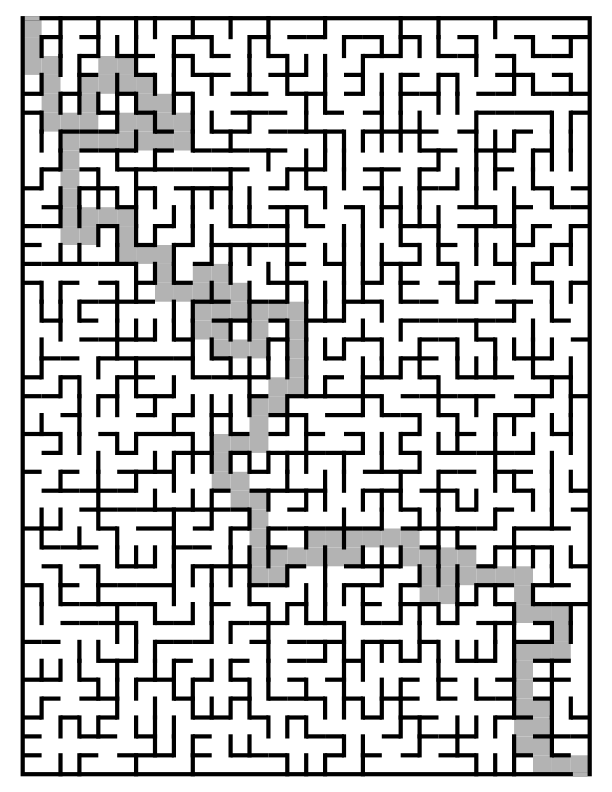

In [31]:
def main(rows, columns, file, papersize):
    grid  = Grid(rows, columns)
    grid  = initWilsonMaze(grid)
    startRow = 0  

    startColumn = 0
    grid.start = grid.getCell(startRow, startColumn)

    goalRow = rows-1 #random.randint(0, rows-1)
    goalColumn = columns-1 
    grid.goal = grid.getCell(goalRow, goalColumn)
    grid.distances = grid.getDistancesFromPath(grid.start, grid.goal)
    surface = grid.drawGrid(file, paper=papersize)
    displayMaze(surface)   
    
main(Rows, Columns, FileName, PaperSize)

     

In [0]:
#@title Output { run: "auto" }
downloadPDF = True #@param {type:"boolean"}
from google.colab import files
if downloadPDF: files.download(FileName)
